In [1]:
# 패키지 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.optimize import minimize
sns.set()

### 데이터셋

In [2]:
# ETF 데이테 다운로드
tickers = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
etf = yf.Tickers(tickers)
data = etf.history(start='2010-01-01', actions=False)
data.drop(['Open', 'High', 'Low', 'Volume'], inplace=True, axis=1)
data = data.droplevel(0, axis=1).resample('M').last()

[*********************100%***********************]  9 of 9 completed


In [3]:
# 수익률 계산
rets = data.pct_change().fillna(0)

In [4]:
# 색깔 팔레트
pal = sns.color_palette('Spectral', len(tickers))

### 최대 분산비율 포트폴리오 최적화 알고리즘

In [5]:
# 공분산행렬
cov = np.array(rets.cov() * 12)

# 각 자산별 변동성
vol = np.diag(cov)

# 초기값 설정
noa = rets.shape[1]
init_guess = np.repeat(1/noa, noa)

# 상하한값
bounds = ((0.0, 1.0), ) * noa

# 제약조건
weights_sum_to_1 = {
    'type': 'eq',
    'fun': lambda weights: np.sum(weights) - 1
}

# 목적함수 : 마이너스 분산비율
def neg_div_ratio(weights, vol, cov):
    weighted_vol = weights.T @ vol
    port_vol = np.sqrt(weights.T @ cov @ weights)
    return - weighted_vol / port_vol

# 가중치 계산
res = minimize(neg_div_ratio,
                init_guess,
                args=(vol, cov),
                method='SLSQP',
                constraints=(weights_sum_to_1),
                bounds=bounds
                )

weights = res.x

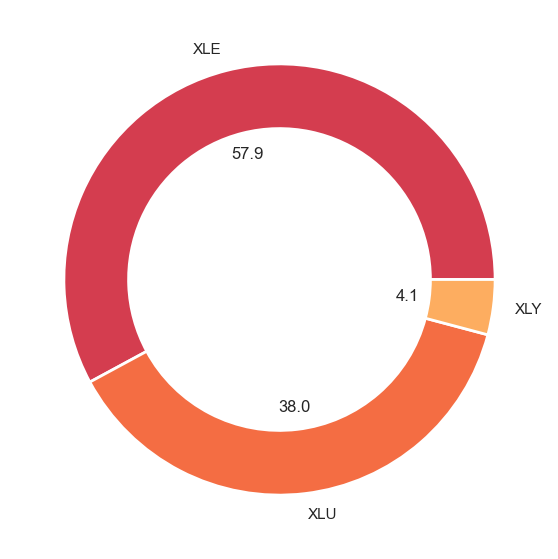

In [6]:
# 가중치 데이터프레임 생성
weights_df = pd.Series(np.round(weights, 4), index=tickers)
weights_df = weights_df[weights_df > 0]

# 파이차트
plt.figure(figsize=(7, 7))
wedgeprops = {'width': 0.3, 
              'edgecolor': 'w',
              'linewidth': 2}

plt.pie(weights_df, labels=weights_df.index, autopct='%.1f', wedgeprops=wedgeprops, colors=pal)
plt.show()

In [7]:
# MDP 포트폴리오가중치 계산 함수
def get_mdp_weights(cov):

    # 자산 개별 변동성
    vol = np.diag(cov)

    # 자산 계수
    noa = cov.shape[0]

    # 초기 가중치 값
    init_guess = np.repeat(1/noa, noa)

    # 제약조건 및 상하한값
    bounds = ((0.0, 1.0), ) * noa
    weights_sum_to_1 = {
        'type': 'eq',
        'fun' : lambda weights: np.sum(weights) - 1
    }

    # 목적함수 : 마이너스 분산비율
    def neg_div_ratio(weights, vol, cov):
        weighted_vol = weights.T @ vol
        port_vol = np.sqrt(weights.T @ cov @ weights)
        return - weighted_vol / port_vol
    
    # 최적화 수행
    res = minimize(neg_div_ratio,
                   init_guess,
                   args=(vol, cov),
                   constraints=(weights_sum_to_1),
                   bounds=bounds)
    
    return res.x

In [8]:
# 빈 데이터프레임 생성
mdp_w_df = pd.DataFrame().reindex_like(rets)

# 공분산행렬 3차원 배일 생성
cov = rets.rolling(12).cov().fillna(0) * 12
cov = cov.values.reshape(int(cov.shape[0] / cov.shape[1]), cov.shape[1], cov.shape[1])

# MDP 가중치 산출
for i in range(12, len(mdp_w_df)):
    mdp_w_df.iloc[i] = get_mdp_weights(cov[i - 1])

Text(0, 0.5, 'Weights')

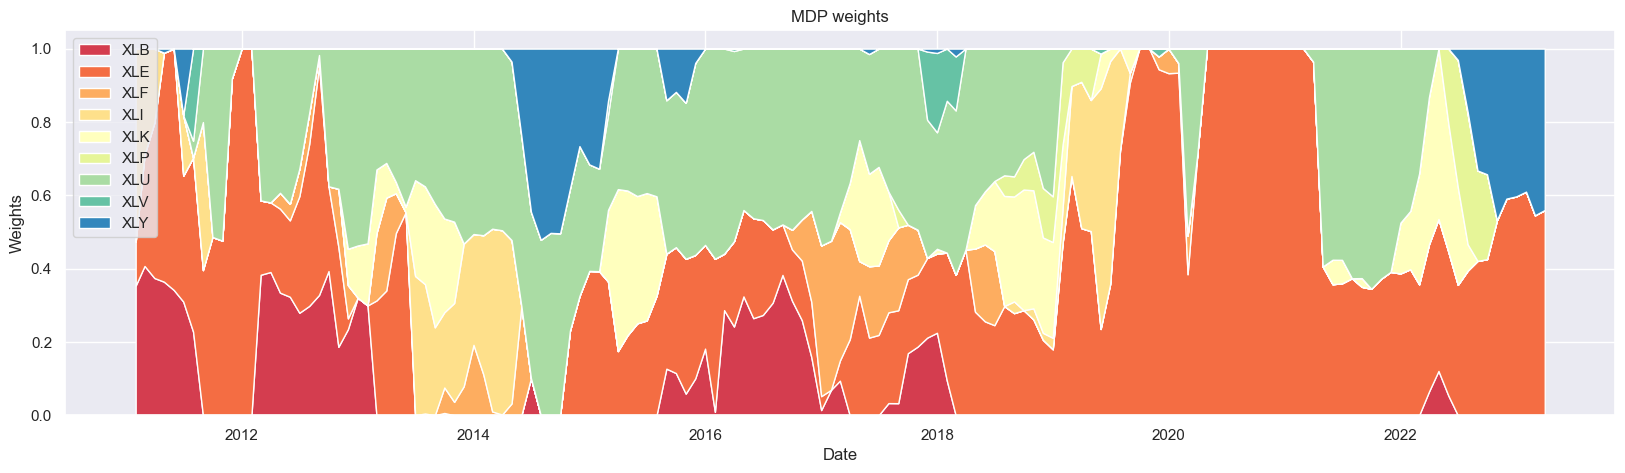

In [9]:
# 가중치 시례열 플랏
plt.figure(figsize=(20, 5))
plt.stackplot(mdp_w_df.index, mdp_w_df.T, labels=mdp_w_df.columns, colors=pal)
plt.legend(loc='upper left')
plt.title('MDP weights')
plt.xlabel('Date')
plt.ylabel('Weights')

Text(0, 0.5, 'Returns')

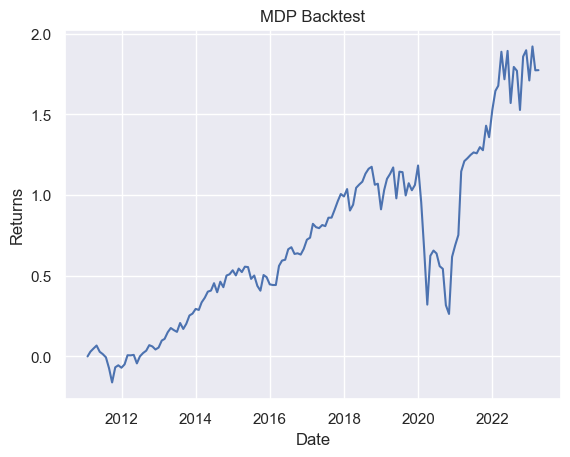

In [10]:
# MDP 포트폴리오 수익률
port_rets = mdp_w_df.shift() * rets
port_cum_rets = (1 + port_rets.sum(axis=1)).cumprod() - 1

# 포트폴리오 백테스팅 결과
plt.plot(port_cum_rets.iloc[12:])
plt.title('MDP Backtest')
plt.xlabel('Date')
plt.ylabel('Returns')